# Set-Up

In [1]:
import jax
import jax.numpy as jnp
from approx_post import losses, optimisers, distributions
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

# Plotting Functions

In [2]:
def plot_data(data, true_theta, model):
    sns.scatterplot(x=true_theta.squeeze(), y=data.squeeze(), label=f"Obsevations")
    sns.lineplot(x=true_theta.squeeze(), y=model(true_theta).squeeze(), label=f"True Relationship", color='r')
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("(Noisy) Observations $x$")
    plt.show()

In [3]:
color_list = ['red', 'blue', 'yellow', 'purple', 'orange', 'pink', 'cyan']
def plot_phi_function(amortised_dist, x, x_obs=None, true_theta=None, model=None):
    # Compute phi:
    if x.ndim < 2:
        x = x[:,None]
    pred_phi = amortised_dist.phi(x)
    
    # Plot mean and standard deviation:
    x_plt = x.squeeze()
    for idx, (key, phi_i) in enumerate(pred_phi.items()):
        if 'component' in key: 
            pred_mean, pred_std = phi_i['mean'].squeeze(), jnp.exp(phi_i['log_chol_diag']).squeeze()
            mean_plus_cov = pred_mean + 2*pred_std
            mean_minus_cov = pred_mean - 2*pred_std
            ax = sns.lineplot(x=x_plt, y=pred_mean, color=color_list[idx], label=f"Predicted Mean for Component {idx+1}")
            sns.lineplot(x=x_plt, y=mean_plus_cov, color=color_list[idx], label=f"Predicted Mean Plus/Minus 2 x Standard Deviation for Component {idx+1}", linestyle='--')
            sns.lineplot(x=x_plt, y=mean_minus_cov, color=color_list[idx], linestyle='--')
            ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color=color_list[idx], alpha=0.2)
    if (data is not None) and (true_theta is not None):
        sns.scatterplot(x=data.squeeze(), y=true_theta.squeeze(), label=f"Observations", color='green') 
    if (model is not None) and (true_theta is not None):
        sns.scatterplot(x=model(true_theta.squeeze()), y=true_theta.squeeze(), label=f"True Relationship", color='black')
    plt.xlabel("Observation $x$")
    plt.ylabel("Parameter $\Theta$")
    plt.show()
    
    plt.figure()
    
    # Plot mixture coefficients:
    coeffs = amortised_dist.coefficients(x=x)
    for idx, coeff_i in enumerate(coeffs.T): 
        sns.lineplot(x=x_plt, y=coeff_i, color=color_list[idx], label=f"Mixture Coefficient for Component {idx+1}")      
    plt.xlabel("Observation $x$")
    plt.ylabel("Mixture Coefficient")
    plt.ylim(ymin = -0.05, ymax = 1.05)
    plt.show()

In [4]:
def plot_posteriors(ammortised_dist, x_list, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-4, 4, 1000)).reshape(1,-1,1)
    for x_i in x_list:
        pdf = jnp.exp(amortised_dist.logpdf(theta, x=jnp.array([[x_i]])))
        ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze(), label=f"x = {x_i:.1f}")
        ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("Posterior Probability Density")

# Artificial Data Creation

In [5]:
def create_data(model, theta, noise_cov, prngkey):
    num_batch = theta.shape[0] 
    mean_vals = model(theta).reshape(num_batch, -1) # shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros(x_dim), cov=noise_cov, shape=(num_batch,)) # shape = (num_batch, dim_x)
    # Add each mean on:
    samples = mean_vals + epsilon # shape = (num_batch, x_dim)
    return samples

In [6]:
# Define model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [7]:
prngkey = jax.random.PRNGKey(42)
num_batch = 100
true_theta = jnp.linspace(-5, 5, num_batch)
noise_cov = 1*jnp.identity(ndim)
data = create_data(model, true_theta, noise_cov, prngkey)

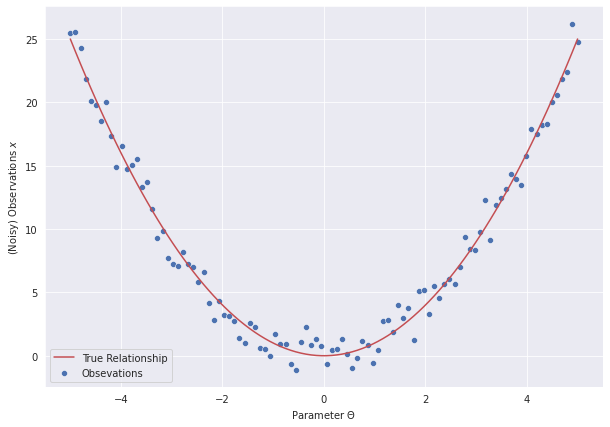

In [8]:
plot_data(data, true_theta, model)

# Create Joint Distribution

In [9]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)
joint_dist = distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Neural Network

In [10]:
prngkey = jax.random.PRNGKey(10)
approx_dist = distributions.approx.Gaussian(ndim)
mix_dist = distributions.mixture.Identical(approx_dist,1)
preprocessing = distributions.amortised.Preprocessing.std_scaling(data)
amortised_dist = distributions.amortised.NeuralNetwork(mix_dist, ndim, prngkey, num_layers=3, width=5, \
                                                       activation='sigmoid', preprocessing=preprocessing)

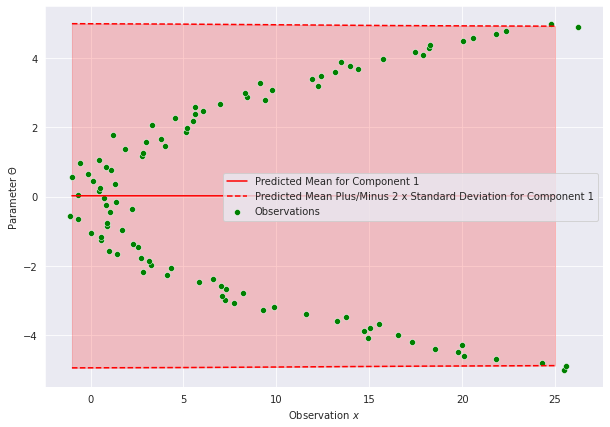

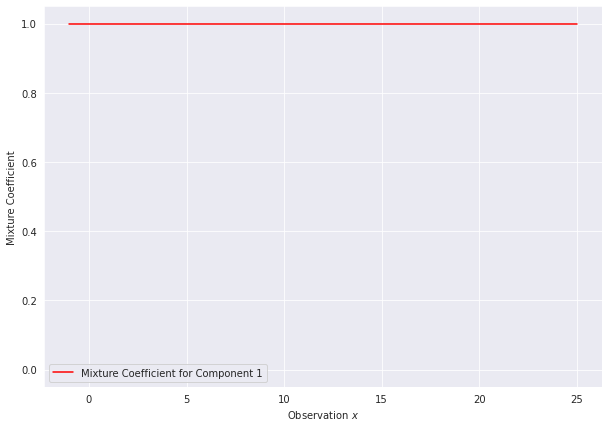

In [11]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [17]:
# Initialise:
target = Jaxtainer({'component_0': {'mean': -2.0, 'log_chol_diag': -0.5}},
                   {'component_1': {'mean': 2.0, 'log_chol_diag': -0.5}})
# target = Jaxtainer({'component_0': {'mean': 0, 'log_chol_diag': 0}})
mse = losses.MSE(target)
optimiser = optimisers.Adam(lr=5e-3)
optimiser.fit(amortised_dist, mse, data, prngkey, max_iter=100, verbose=True)

Loss = 884.4835815429688, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7591358 , -0.02973867,  2.3793876 ,  1.2182703 ,
               0.40732157]], dtype=float32), 'b_0': DeviceArray([-0.00499999, -0.00499996,  0.00499998,  0.00499999,
             -0.005     ], dtype=float32), 'W_1': DeviceArray([[-0.06066358, -0.45731136, -0.57081705, -0.40556714,
               0.4293586 ],
             [-0.38993075,  1.175614  , -1.2469593 ,  0.5060226 ,
               0.08742529],
             [-0.46566457,  0.84299886,  0.12307294,  0.38274735,
              -0.33791187],
             [-0.21778592,  1.0908867 ,  0.7755841 , -0.42411828,
              -0.75266016],
             [-1.2449256 ,  0.80219656,  1.020199  ,  0.57591695,
               1.1448979 ]], dtype=float32), 'b_1': DeviceArray([ 0.005     ,  0.00499999,  0.00499999,  0.005     ,
             -0.005     ], dtype=float32), 'W_2': DeviceArray([[ 0.30121264,  0.04195708,  0.86888206, -0.57234496,
              -0.817652

Loss = 817.594482421875, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.74916816, -0.03961059,  2.3694463 ,  1.2083223 ,
               0.3995122 ]], dtype=float32), 'b_0': DeviceArray([-0.01496084, -0.01501897,  0.01494846,  0.01494811,
             -0.01496666], dtype=float32), 'W_1': DeviceArray([[-0.05065433, -0.44738892, -0.56082684, -0.39555845,
               0.41940743],
             [-0.37992105,  1.1855378 , -1.2369697 ,  0.51603144,
               0.07747509],
             [-0.45565262,  0.8529274 ,  0.13306354,  0.39275798,
              -0.34786376],
             [-0.207774  ,  1.1008158 ,  0.7855755 , -0.41410753,
              -0.7626131 ],
             [-1.2349157 ,  0.8121205 ,  1.0301882 ,  0.5859259 ,
               1.1349481 ]], dtype=float32), 'b_1': DeviceArray([ 0.01501049,  0.0149253 ,  0.01499099,  0.01500971,
             -0.0149523 ], dtype=float32), 'W_2': DeviceArray([[ 0.29121995,  0.03195786,  0.87888646, -0.562334  ,
              -0.8276344

Loss = 753.8377685546875, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.73928785, -0.04909085,  2.3596776 ,  1.1985242 ,
               0.39976946]], dtype=float32), 'b_0': DeviceArray([-0.02481559, -0.02508188,  0.02474722,  0.02474873,
             -0.02484432], dtype=float32), 'W_1': DeviceArray([[-0.04062271, -0.43768188, -0.5508644 , -0.38553184,
               0.4095928 ],
             [-0.36988774,  1.1952498 , -1.2270094 ,  0.5260584 ,
               0.067664  ],
             [-0.44561124,  0.86265683,  0.14302666,  0.4027911 ,
              -0.35768065],
             [-0.19773273,  1.1105466 ,  0.7955417 , -0.40407372,
              -0.77243376],
             [-1.2248818 ,  0.82183236,  1.0401472 ,  0.5959531 ,
               1.1251382 ]], dtype=float32), 'b_1': DeviceArray([ 0.02504654,  0.02464258,  0.02495603,  0.02503995,
             -0.02477087], dtype=float32), 'W_2': DeviceArray([[ 0.2812483 ,  0.02196196,  0.88894296, -0.55229735,
              -0.837568

Loss = 693.3453369140625, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.72955406, -0.05781921,  2.3502312 ,  1.188998  ,
               0.40563244]], dtype=float32), 'b_0': DeviceArray([-0.03449261, -0.03520568,  0.03427289,  0.03428788,
             -0.0345759 ], dtype=float32), 'W_1': DeviceArray([[-0.0305581 , -0.42834467, -0.54095083, -0.3754843 ,
               0.40001526],
             [-0.35981962,  1.2045975 , -1.217101  ,  0.5361063 ,
               0.05809393],
             [-0.43552575,  0.8720427 ,  0.15294008,  0.41285154,
              -0.36726254],
             [-0.18764758,  1.1199342 ,  0.8054621 , -0.39401147,
              -0.7820237 ],
             [-1.2148128 ,  0.8311784 ,  1.0500525 ,  0.6060012 ,
               1.1155704 ]], dtype=float32), 'b_1': DeviceArray([ 0.03512062,  0.03400132,  0.03487469,  0.03509504,
             -0.03435661], dtype=float32), 'W_2': DeviceArray([[ 0.2713138 ,  0.01197351,  0.89910185, -0.5422245 ,
              -0.84742 

Loss = 636.211669921875, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.72003454, -0.06532471,  2.3413093 ,  1.179901  ,
               0.41366586]], dtype=float32), 'b_0': DeviceArray([-0.04391323, -0.04540215,  0.04336681,  0.0434267 ,
             -0.04410297], dtype=float32), 'W_1': DeviceArray([[-0.02045159, -0.41955155, -0.53111094, -0.3654178 ,
               0.3907925 ],
             [-0.34970722,  1.2134082 , -1.2072706 ,  0.5461727 ,
               0.04888363],
             [-0.42538315,  0.8809202 ,  0.16277686,  0.42293853,
              -0.37649208],
             [-0.1775057 ,  1.1288116 ,  0.8153118 , -0.3839208 ,
              -0.7912668 ],
             [-1.2046993 ,  0.83998525,  1.0598767 ,  0.61606723,
               1.1063638 ]], dtype=float32), 'b_1': DeviceArray([ 0.04524349,  0.04283011,  0.04472255,  0.04517413,
             -0.04359292], dtype=float32), 'W_2': DeviceArray([[ 0.26143554,  0.00199847,  0.9093999 , -0.5321083 ,
              -0.8571537

Loss = 582.4910278320312, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.71080625, -0.07107639,  2.333175  ,  1.1714311 ,
               0.42278993]], dtype=float32), 'b_0': DeviceArray([-0.05299323, -0.05567852,  0.0518307 ,  0.05200106,
             -0.05336901], dtype=float32), 'W_1': DeviceArray([[-0.01029603, -0.41148943, -0.5213728 , -0.35533914,
               0.38205808],
             [-0.33954296,  1.2214957 , -1.197548  ,  0.5562501 ,
               0.04016721],
             [-0.41517204,  0.88910985,  0.17250606,  0.43304598,
              -0.3852357 ],
             [-0.16729599,  1.1369957 ,  0.8250618 , -0.3738068 ,
              -0.80002993],
             [-1.1945337 ,  0.8480684 ,  1.0695887 ,  0.6261434 ,
               1.0976524 ]], dtype=float32), 'b_1': DeviceArray([ 0.05542419,  0.05094292,  0.05447173,  0.05527152,
             -0.05234663], dtype=float32), 'W_2': DeviceArray([[ 0.25163537, -0.00795539,  0.91986126, -0.52194494,
              -0.866729

Loss = 532.1976318359375, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.70195466, -0.07460908,  2.3261514 ,  1.1638252 ,
               0.43260098]], dtype=float32), 'b_0': DeviceArray([-0.06164489, -0.06603783,  0.05942721,  0.05982487,
             -0.06232238], dtype=float32), 'W_1': DeviceArray([[-8.6029526e-05, -4.0434614e-01, -5.1176697e-01,
              -3.4525928e-01,  3.7395814e-01],
             [-3.2932112e-01,  1.2286724e+00, -1.1879658e+00,
               5.6632674e-01,  3.2090351e-02],
             [-4.0488267e-01,  8.9642751e-01,  1.8209334e-01,
               4.4316313e-01, -3.9334667e-01],
             [-1.5700921e-01,  1.1442965e+00,  8.3467990e-01,
              -3.6367941e-01, -8.0816603e-01],
             [-1.1843096e+00,  8.5524428e-01,  1.0791546e+00,
               6.3621753e-01,  1.0895820e+00]], dtype=float32), 'b_1': DeviceArray([ 0.06566995,  0.05814993,  0.06409141,  0.06537709,
             -0.06047108], dtype=float32), 'W_2': DeviceArray([[

Loss = 485.3065185546875, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.693572  , -0.07567583,  2.3205984 ,  1.1573488 ,
               0.4428932 ]], dtype=float32), 'b_0': DeviceArray([-0.06977937, -0.07647927,  0.06589007,  0.06669869,
             -0.0709189 ], dtype=float32), 'W_1': DeviceArray([[ 0.010182  , -0.39829525, -0.5023261 , -0.3351929 ,
               0.3666449 ],
             [-0.31903803,  1.234764  , -1.1785582 ,  0.5763867 ,
               0.02480381],
             [-0.39450726,  0.9026976 ,  0.19150178,  0.45327473,
              -0.40067124],
             [-0.14663821,  1.1505313 ,  0.84413123, -0.35355288,
              -0.8155196 ],
             [-1.1740226 ,  0.86134475,  1.0885388 ,  0.64627355,
               1.0823026 ]], dtype=float32), 'b_1': DeviceArray([ 0.07598615,  0.06427224,  0.07354861,  0.07547676,
             -0.06781206], dtype=float32), 'W_2': DeviceArray([[ 0.2323687 , -0.02775986,  0.94132227, -0.50147897,
              -0.885235

Loss = 441.75567626953125, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.68575454, -0.07431622,  2.3168569 ,  1.1522694 ,
               0.45353198]], dtype=float32), 'b_0': DeviceArray([-0.07730946, -0.08699814,  0.07094824,  0.07242472,
             -0.07912396], dtype=float32), 'W_1': DeviceArray([[ 0.02050983, -0.39348   , -0.49308357, -0.32515788,
               0.36026776],
             [-0.30869216,  1.2396263 , -1.1693611 ,  0.58641064,
               0.01845432],
             [-0.3840402 ,  0.9077687 ,  0.20069289,  0.46336162,
              -0.40705734],
             [-0.13617808,  1.155541  ,  0.8533793 , -0.3434454 ,
              -0.82193553],
             [-1.1636695 ,  0.86623263,  1.0977045 ,  0.65629196,
               1.0759603 ]], dtype=float32), 'b_1': DeviceArray([ 0.08637621,  0.06915835,  0.08280908,  0.08555299,
             -0.07421653], dtype=float32), 'W_2': DeviceArray([[ 0.22295646, -0.03758682,  0.9523285 , -0.49118602,
              -0.89407

Loss = 401.45025634765625, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.678599  , -0.07079291,  2.315172  ,  1.1488173 ,
               0.46441168]], dtype=float32), 'b_0': DeviceArray([-0.08415227, -0.09758583,  0.07436397,  0.07682732,
             -0.08691367], dtype=float32), 'W_1': DeviceArray([[ 0.03089732, -0.3899995 , -0.48407283, -0.3151748 ,
               0.35496247],
             [-0.29828405,  1.24316   , -1.16041   ,  0.5963762 ,
               0.01317354],
             [-0.37347823,  0.91152817,  0.20962779,  0.47340125,
              -0.41236567],
             [-0.12562639,  1.1592069 ,  0.862387  , -0.33337852,
              -0.82727057],
             [-1.1532493 ,  0.8698139 ,  1.1066155 ,  0.6662505 ,
               1.0706866 ]], dtype=float32), 'b_1': DeviceArray([ 0.09684139,  0.07269913,  0.09183837,  0.09558532,
             -0.07954383], dtype=float32), 'W_2': DeviceArray([[ 0.21372998, -0.0473457 ,  0.9635137 , -0.48086497,
              -0.90258

Loss = 364.2681579589844, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6721977 , -0.06546832,  2.3156276 ,  1.1471426 ,
               0.4754391 ]], dtype=float32), 'b_0': DeviceArray([-0.09023198, -0.10822958,  0.07597555,  0.07977495,
             -0.09427507], dtype=float32), 'W_1': DeviceArray([[ 0.04134225, -0.387901  , -0.47532603, -0.3052661 ,
               0.35083938],
             [-0.2878167 ,  1.2453183 , -1.1517394 ,  0.60625875,
               0.00906696],
             [-0.3628208 ,  0.9139127 ,  0.21826841,  0.4833682 ,
              -0.4164815 ],
             [-0.11498347,  1.1614621 ,  0.8711176 , -0.3233768 ,
              -0.8314055 ],
             [-1.1427629 ,  0.87204516,  1.115237  ,  0.67612493,
               1.066587  ]], dtype=float32), 'b_1': DeviceArray([ 0.1073807 ,  0.0748375 ,  0.10060296,  0.10555089,
             -0.08367759], dtype=float32), 'W_2': DeviceArray([[ 0.2047188 , -0.05702186,  0.9748687 , -0.4705285 ,
              -0.910717

Loss = 330.0655822753906, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.66663325, -0.058708  ,  2.318134  ,  1.1472862 ,
               0.48652598]], dtype=float32), 'b_0': DeviceArray([-0.09548239, -0.11891218,  0.07572778,  0.08119766,
             -0.10120533], dtype=float32), 'W_1': DeviceArray([[ 0.05184016, -0.3871789 , -0.4668731 , -0.295456  ,
               0.34797385],
             [-0.2772955 ,  1.2461085 , -1.143381  ,  0.6160319 ,
               0.00620451],
             [-0.3520702 ,  0.9149119 ,  0.22657879,  0.49323466,
              -0.41932502],
             [-0.10425266,  1.1622962 ,  0.8795363 , -0.3134672 ,
              -0.8342565 ],
             [-1.1322134 ,  0.8729333 ,  1.1235366 ,  0.68588924,
               1.0637326 ]], dtype=float32), 'b_1': DeviceArray([ 0.11799061,  0.07557098,  0.1090713 ,  0.11542499,
             -0.08653641], dtype=float32), 'W_2': DeviceArray([[ 0.1959526 , -0.06659999,  0.9863809 , -0.46019223,
              -0.918432

Loss = 298.6832580566406, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.66197294, -0.05083529,  2.3224726 ,  1.1491783 ,
               0.49758556]], dtype=float32), 'b_0': DeviceArray([-0.09984905, -0.12961178,  0.07367659,  0.08109461,
             -0.10771017], dtype=float32), 'W_1': DeviceArray([[ 0.06238417, -0.38778076, -0.45874074, -0.28576946,
               0.34640023],
             [-0.26672852,  1.2455856 , -1.1353638 ,  0.6256681 ,
               0.0046153 ],
             [-0.34123185,  0.91456497,  0.23452634,  0.50297135,
              -0.4208583 ],
             [-0.09344043,  1.1617516 ,  0.8876111 , -0.30367848,
              -0.8357823 ],
             [-1.1216062 ,  0.87253   ,  1.1314857 ,  0.6955166 ,
               1.0621544 ]], dtype=float32), 'b_1': DeviceArray([ 0.12866484,  0.07494687,  0.11721486,  0.12518157,
             -0.08808075], dtype=float32), 'W_2': DeviceArray([[ 1.8746074e-01, -7.6064467e-02,  9.9803424e-01,
              -4.4987431e-0

Loss = 269.9522399902344, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.658264  , -0.04212127,  2.3283598 ,  1.1526617 ,
               0.50853115]], dtype=float32), 'b_0': DeviceArray([-0.10329125, -0.14030159,  0.06996775,  0.07952955,
             -0.1138017 ], dtype=float32), 'W_1': DeviceArray([[ 0.07296479, -0.38961747, -0.45095167, -0.27623218,
               0.3461107 ],
             [-0.25612658,  1.2438416 , -1.1277122 ,  0.6351391 ,
               0.00428702],
             [-0.3303143 ,  0.91295165,  0.242083  ,  0.5125479 ,
              -0.42108655],
             [-0.08255656,  1.159914  ,  0.89531404, -0.29404062,
              -0.8359869 ],
             [-1.1109498 ,  0.8709217 ,  1.1390601 ,  0.7049794 ,
               1.0618427 ]], dtype=float32), 'b_1': DeviceArray([ 0.13939421,  0.07305241,  0.12500897,  0.1347937 ,
             -0.08831487], dtype=float32), 'W_2': DeviceArray([[ 0.1792718 , -0.08539959,  1.0098099 , -0.43959504,
              -0.932464

Loss = 243.698974609375, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.65552926, -0.03279012,  2.3355012 ,  1.1575271 ,
               0.5192758 ]], dtype=float32), 'b_0': DeviceArray([-0.10578347, -0.1509499 ,  0.06480238,  0.07661734,
             -0.1194962 ], dtype=float32), 'W_1': DeviceArray([[ 0.08356977, -0.39257482, -0.44352418, -0.26686987,
               0.34705898],
             [-0.24550343,  1.240994  , -1.1204458 ,  0.6444166 ,
               0.00517001],
             [-0.3193294 ,  0.9101811 ,  0.24922611,  0.52193373,
              -0.42005512],
             [-0.0716142 ,  1.1569    ,  0.90262216, -0.2845841 ,
              -0.8349158 ],
             [-1.100255  ,  0.8682188 ,  1.1462408 ,  0.71425027,
               1.062751  ]], dtype=float32), 'b_1': DeviceArray([ 0.15016642,  0.07000273,  0.13243344,  0.14423403,
             -0.0872835 ], dtype=float32), 'W_2': DeviceArray([[ 0.17141336, -0.09458994,  1.0216863 , -0.4293767 ,
              -0.9387210

KeyboardInterrupt: 

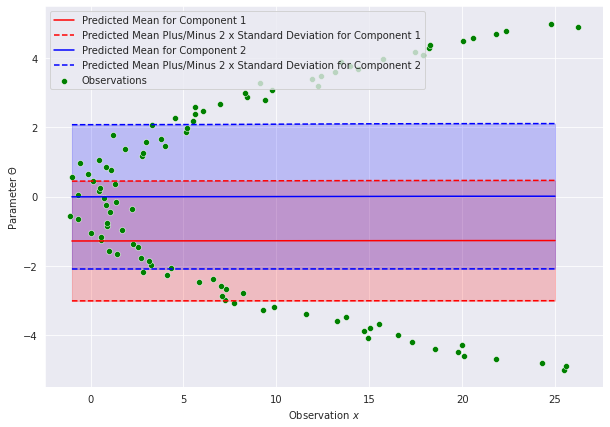

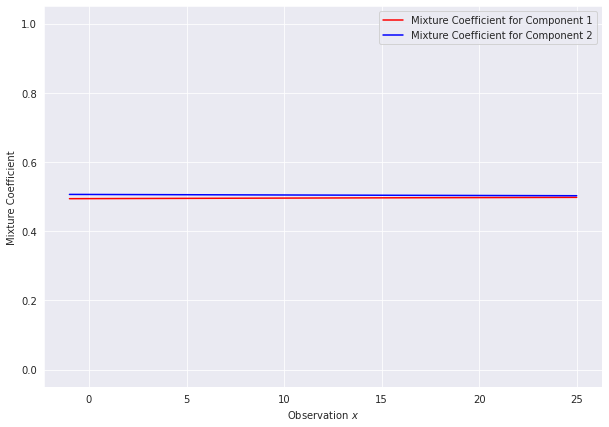

In [13]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [14]:
prngkey = jax.random.PRNGKey(20)
loss = losses.SELBO(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=200)

Loss = 55.90911102294922, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.77679175, -0.02361326,  2.5417302 ,  1.1496043 ,
               0.70593244]], dtype=float32), 'b_0': DeviceArray([ 0.02502823, -0.15649585, -0.13783163, -0.10461419,
             -0.2612101 ], dtype=float32), 'W_1': DeviceArray([[ 0.30034184, -0.3674575 , -0.48521042, -0.27911913,
               0.513449  ],
             [-0.0292253 ,  1.2692406 , -1.1654334 ,  0.62948287,
               0.16879182],
             [-0.09550998,  0.93540794,  0.20091757,  0.50794363,
              -0.25175583],
             [ 0.15073591,  1.1798756 ,  0.8569365 , -0.29737508,
              -0.6659082 ],
             [-0.8813506 ,  0.8970965 ,  1.0999734 ,  0.6995923 ,
               1.2279904 ]], dtype=float32), 'b_1': DeviceArray([0.3698149 , 0.09289762, 0.08986246, 0.13253865, 0.08118715],            dtype=float32), 'W_2': DeviceArray([[ 0.21163702, -0.28616887,  1.256346  , -0.22382805,
              -0.87101483],
  

Loss = 51.89404296875, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.64215803,  0.0884037 ,  2.4110124 ,  0.95980865,
               0.56039053]], dtype=float32), 'b_0': DeviceArray([-0.10053881, -0.28928733,  0.00385029,  0.01695314,
             -0.12508392], dtype=float32), 'W_1': DeviceArray([[ 0.4479828 , -0.49517417, -0.35334536, -0.14804067,
               0.40306953],
             [ 0.11636017,  1.1398014 , -1.0339653 ,  0.7592701 ,
               0.06217467],
             [ 0.04737954,  0.79989165,  0.33177972,  0.6345721 ,
              -0.34303883],
             [ 0.29476213,  1.0472044 ,  0.98781276, -0.16991296,
              -0.7616999 ],
             [-0.73646647,  0.76715434,  1.2303097 ,  0.8269966 ,
               1.1307157 ]], dtype=float32), 'b_1': DeviceArray([ 0.51626366, -0.03596356,  0.22123335,  0.26223496,
             -0.02412833], dtype=float32), 'W_2': DeviceArray([[ 0.08336793, -0.16926649,  1.4054683 , -0.3145186 ,
              -0.9955118 ]

Loss = 47.681396484375, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.5523192 ,  0.15201108,  2.3409722 ,  0.91844106,
               0.4652118 ]], dtype=float32), 'b_0': DeviceArray([-0.17238975, -0.38152072,  0.11072119,  0.06893329,
             -0.01689453], dtype=float32), 'W_1': DeviceArray([[ 0.5587515 , -0.5831244 , -0.2654093 , -0.0618004 ,
               0.3689068 ],
             [ 0.2249688 ,  1.0500861 , -0.94650024,  0.8436104 ,
               0.03753373],
             [ 0.15437606,  0.7020505 ,  0.41910616,  0.71455795,
              -0.33064875],
             [ 0.40279916,  0.9535611 ,  1.0743526 , -0.08928833,
              -0.7588268 ],
             [-0.62766343,  0.67625064,  1.3160837 ,  0.90755314,
               1.1301275 ]], dtype=float32), 'b_1': DeviceArray([ 0.6262097 , -0.12543905,  0.3085286 ,  0.34636742,
             -0.04495994], dtype=float32), 'W_2': DeviceArray([[ 0.00810863, -0.12405696,  1.5354335 , -0.2943662 ,
              -1.0531589 

Loss = 39.597835540771484, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.49275294,  0.19756255,  2.3203354 ,  1.0108968 ,
               0.4246694 ]], dtype=float32), 'b_0': DeviceArray([-0.22016051, -0.45618275,  0.19404219,  0.08327974,
              0.07124942], dtype=float32), 'W_1': DeviceArray([[ 6.3761401e-01, -6.5175885e-01, -2.0217429e-01,
              -1.1021066e-03,  3.6350113e-01],
             [ 3.0157331e-01,  9.8102522e-01, -8.8314641e-01,
               9.0284306e-01,  4.1648887e-02],
             [ 2.2874804e-01,  6.2699234e-01,  4.8397940e-01,
               7.7053905e-01, -2.8730255e-01],
             [ 4.7745708e-01,  8.8134903e-01,  1.1373436e+00,
              -3.3708956e-02, -7.2454828e-01],
             [-5.5255246e-01,  6.0542017e-01,  1.3779889e+00,
               9.6274185e-01,  1.1618011e+00]], dtype=float32), 'b_1': DeviceArray([ 0.7035193 , -0.19516449,  0.37148023,  0.4050553 ,
             -0.03551953], dtype=float32), 'W_2': DeviceArray([

Loss = 37.95997619628906, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.462968  ,  0.22542495,  2.3012981 ,  1.1312886 ,
               0.38527822]], dtype=float32), 'b_0': DeviceArray([-0.25090477, -0.51448977,  0.27099538,  0.08789639,
              0.1542816 ], dtype=float32), 'W_1': DeviceArray([[ 0.70158947, -0.7128413 , -0.15125568,  0.04833692,
               0.37112808],
             [ 0.36143595,  0.92069596, -0.83208454,  0.95086706,
               0.05562622],
             [ 0.28565884,  0.55905795,  0.5378536 ,  0.81765056,
              -0.23874243],
             [ 0.5343615 ,  0.81630975,  1.1891586 ,  0.01236869,
              -0.6836945 ],
             [-0.49395305,  0.53981656,  1.4290733 ,  1.0088466 ,
               1.2026515 ]], dtype=float32), 'b_1': DeviceArray([ 0.76511973, -0.25799832,  0.42264137,  0.45327565,
             -0.0147613 ], dtype=float32), 'W_2': DeviceArray([[-0.0758724 , -0.11949496,  1.7480984 , -0.1555261 ,
              -1.076694

Loss = 39.78105926513672, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.46822348,  0.23115799,  2.255714  ,  1.2493739 ,
               0.3112437 ]], dtype=float32), 'b_0': DeviceArray([-0.25855175, -0.54965276,  0.34851828,  0.08635686,
              0.24362823], dtype=float32), 'W_1': DeviceArray([[ 0.76827955, -0.7704367 , -0.10826049,  0.09299351,
               0.39751643],
             [ 0.42126277,  0.8648263 , -0.78915554,  0.99382854,
               0.08316445],
             [ 0.34610757,  0.49039343,  0.5843716 ,  0.86275476,
              -0.17707033],
             [ 0.59395134,  0.75310874,  1.2336793 ,  0.05572939,
              -0.63066536],
             [-0.42861217,  0.4737826 ,  1.4735689 ,  1.0535247 ,
               1.2616832 ]], dtype=float32), 'b_1': DeviceArray([ 0.83057743, -0.31850845,  0.4662958 ,  0.49784574,
              0.02392129], dtype=float32), 'W_2': DeviceArray([[-0.11244688, -0.07902696,  1.8172725 , -0.12826712,
              -1.117752

Loss = 37.05440902709961, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.5007393 ,  0.22514287,  2.2023923 ,  1.382276  ,
               0.20649041]], dtype=float32), 'b_0': DeviceArray([-0.2516487 , -0.5701527 ,  0.42318588,  0.078008  ,
              0.33202273], dtype=float32), 'W_1': DeviceArray([[ 0.83265   , -0.8233004 , -0.072292  ,  0.13205716,
               0.43496162],
             [ 0.47751772,  0.8153717 , -0.7532823 ,  1.0311384 ,
               0.11563819],
             [ 0.40596136,  0.42752042,  0.62435186,  0.90399784,
              -0.11450016],
             [ 0.6515153 ,  0.6971113 ,  1.2715322 ,  0.09454682,
              -0.5781637 ],
             [-0.36267594,  0.41201907,  1.5116597 ,  1.0943396 ,
               1.3275899 ]], dtype=float32), 'b_1': DeviceArray([ 0.89441633, -0.3740061 ,  0.50310004,  0.5373526 ,
              0.0709165 ], dtype=float32), 'W_2': DeviceArray([[-0.14536892, -0.02397547,  1.8693428 , -0.11978227,
              -1.172084

Loss = 37.040828704833984, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.54760236,  0.21737881,  2.1708772 ,  1.5364536 ,
               0.0855184 ]], dtype=float32), 'b_0': DeviceArray([-0.24490745, -0.5857997 ,  0.49039003,  0.0694484 ,
              0.40173864], dtype=float32), 'W_1': DeviceArray([[ 0.8866091 , -0.8663659 , -0.04334537,  0.16382651,
               0.46664804],
             [ 0.52390605,  0.77791214, -0.72417617,  1.0614529 ,
               0.13667679],
             [ 0.45648962,  0.38674212,  0.65769285,  0.93831176,
              -0.0787688 ],
             [ 0.69882405,  0.65990245,  1.3026481 ,  0.12625694,
              -0.55071145],
             [-0.3077214 ,  0.36647907,  1.5423807 ,  1.1274376 ,
               1.3733547 ]], dtype=float32), 'b_1': DeviceArray([ 0.9476247 , -0.41699088,  0.5328395 ,  0.5694748 ,
              0.10568005], dtype=float32), 'W_2': DeviceArray([[-0.17180495,  0.01885467,  1.9113318 , -0.11342441,
              -1.21856

Loss = 38.170711517333984, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6011336 ,  0.21130866,  2.175075  ,  1.7068403 ,
              -0.04606933]], dtype=float32), 'b_0': DeviceArray([-0.24462865, -0.601055  ,  0.54763156,  0.06240996,
              0.44484833], dtype=float32), 'W_1': DeviceArray([[ 0.9285998 , -0.89862514, -0.02101179,  0.188458  ,
               0.48577246],
             [ 0.55965537,  0.75330055, -0.7012723 ,  1.0850617 ,
               0.14072573],
             [ 0.49583688,  0.3727403 ,  0.6845578 ,  0.96512777,
              -0.07922122],
             [ 0.73474747,  0.64409363,  1.3274354 ,  0.15075223,
              -0.5555048 ],
             [-0.26663733,  0.34023494,  1.565478  ,  1.1520567 ,
               1.3889242 ]], dtype=float32), 'b_1': DeviceArray([ 0.98850244, -0.44574183,  0.55583066,  0.59417474,
              0.12043369], dtype=float32), 'W_2': DeviceArray([[-0.19109057,  0.04001712,  1.9464852 , -0.101567  ,
              -1.25213

Loss = 37.91081619262695, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6577485 ,  0.20627916,  2.2087464 ,  1.8831962 ,
              -0.1892159 ]], dtype=float32), 'b_0': DeviceArray([-0.25017506, -0.6164985 ,  0.5957833 ,  0.05696434,
              0.4651557 ], dtype=float32), 'W_1': DeviceArray([[ 0.96065015, -0.9221226 , -0.00411528,  0.20728846,
               0.4941399 ],
             [ 0.58678925,  0.7389334 , -0.68344665,  1.1032268 ,
               0.13068879],
             [ 0.52609044,  0.38023555,  0.70595974,  0.9856357 ,
              -0.10899602],
             [ 0.7616381 ,  0.645343  ,  1.3470324 ,  0.16934362,
              -0.5863858 ],
             [-0.23699582,  0.3290292 ,  1.5821387 ,  1.1696807 ,
               1.3803903 ]], dtype=float32), 'b_1': DeviceArray([ 1.0192648 , -0.4629544 ,  0.5732728 ,  0.6128293 ,
              0.11822367], dtype=float32), 'W_2': DeviceArray([[-0.20435873,  0.04292136,  1.976196  , -0.0841908 ,
              -1.275162

KeyboardInterrupt: 

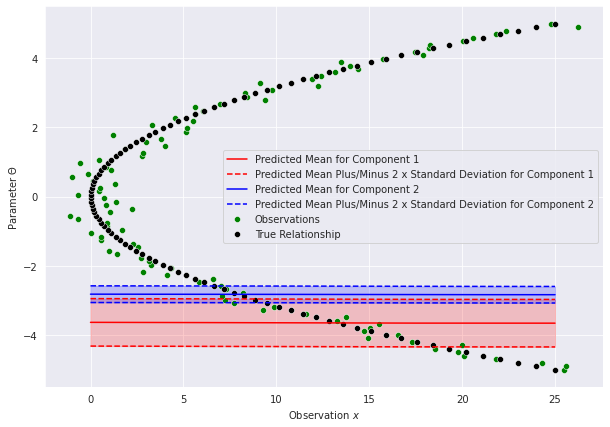

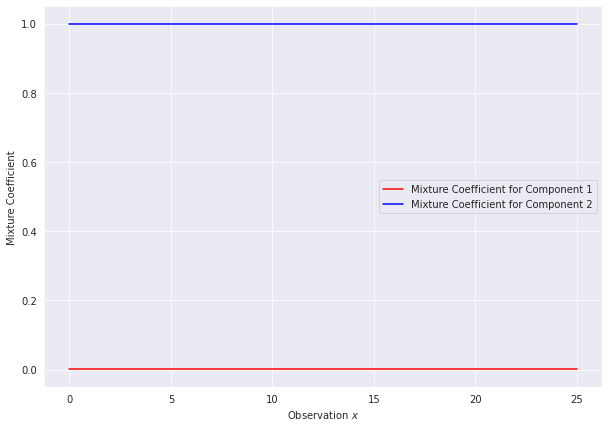

In [17]:
x_plt = jnp.linspace(0,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model)

In [16]:
amortised_dist.add_component()

NameError: name 'copy' is not defined

In [ ]:
x_vals = jnp.linspace(-5,25,7)
plot_posteriors(amortised_dist, x_vals)

# Linear Regression

In [ ]:
prngkey = jax.random.PRNGKey(10)
approx_dist = approx.Gaussian(ndim)
preprocessing = amortised.Preprocessing.range_scaling(data)
amortised_dist = amortised.LinearRegression(approx_dist, ndim, prngkey, order=20, preprocessing=preprocessing)

In [ ]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [ ]:
amortised_dist.initialise(data)

In [ ]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [ ]:
prngkey = jax.random.PRNGKey(42)
loss = losses.ReverseKL(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=200)

In [ ]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model)

In [ ]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)